In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import pandas as pd
import os
import rasterstats as rs
from scipy.stats import linregress
from rasterstats import zonal_stats, point_query

In [12]:
S2_NDCI = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/Sentinel-2_BSL_NDCI_gp.tif'
S3_NDCI = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/Sentinel-3_BSL_NDCI_gp.tif'
PS_NDCI = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/PlanetScope_BSL_NDCI_gp.tif'
sampling_points = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/23_BSL/9_11_23_loqate/9_11_23.shp'
out = '/mnt/nfs/lss/meerdink/data/backed_up/skzebarth/24_spring/GP_GP_Final/'

In [15]:
def rs(image, points, save=False):
    NDCI = rio.open(image)
    SP = gpd.read_file(points)
    SP_transform = SP.to_crs(32615)
    
    string_split = image.split('/')
    name = string_split[-1].split('_')[0]
    
    chl = SP['Value']
    
    R_ZS = zonal_stats(SP_transform, image)
    R_PQ = point_query(SP_transform, image)
    
    mean = [point['mean'] for point in R_ZS]
    
    pixel = np.array(mean)
    chla = np.array(chl)
    ipixel = np.array(R_PQ)
    
    df = pd.DataFrame({'pixel': pixel, 'chla': chla, 'ipixel': ipixel})
    df_clean = df.dropna(subset=['pixel', 'ipixel'])
    df_semifinal = df_clean[(df_clean['pixel'] <=1) & (df_clean['pixel'] >= -1)]
    df_final = df_semifinal[(df_semifinal['ipixel'] <=1) & (df_semifinal['ipixel'] >= -1)]
    
    print(df_final)
    
    cleaned_pixel = list(df_semifinal['pixel'])
    cleaned_chla = list(df_semifinal['chla'])
    cleaned_pixel1 = (df_final['pixel'])
    cleaned_chla2 = list(df_final['chla'])
    cleaned_ipixel = list(df_final['ipixel'])

    slope, intercept, r_value, p_value, std_err = linregress(cleaned_pixel, cleaned_chla)
    r_squared = r_value**2
    print(f'With individual pixels, p:{p_value: .3f} and r2:{r_squared}')
    
    slopei, intercepti, r_valuei, p_valuei, std_erri = linregress(cleaned_ipixel, cleaned_chla2)
    r_squaredi = r_valuei**2
    print(f'With interpolated pixel values, p:{p_valuei: .3f} and r2:{r_squaredi}')
    
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    
    sns.regplot(x=cleaned_pixel, y=cleaned_chla, ax=ax1)
    ax1.set_xlabel('Closest Pixel NDCI')
    ax1.set_ylabel('In-Situ Chl-a')
    ax1.text(.05, .95, f'$R^2 = {r_squared: .3f}$', transform=ax1.transAxes, verticalalignment='top', fontsize=14)
    ax1.text(.05, .88, f'$p = {p_value: .3f}$', transform=ax1.transAxes, verticalalignment='top', fontsize=14)
    
    sns.regplot(x=cleaned_ipixel, y=cleaned_chla, ax=ax2)
    ax2.set_xlabel('Pixel Interpolation NDCI')
    ax2.set_ylabel('In-Situ Chl-a')
    ax2.text(.05, .95, f'$R^2 = {r_squaredi: .3f}$', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
    ax2.text(.05, .88, f'$p = {p_valuei: .3f}$', transform=ax2.transAxes, verticalalignment='top', fontsize=14)
    
    fig.suptitle(f'{name} NDCI Comparison', fontsize=16, fontweight = 'bold')
    plt.tight_layout()
    if save == True:
        plt.savefig(os.path.join(out, f'{name}_NDCI_comparison'), dpi=1200, bbox_inches='tight')
    plt.show()

       pixel  chla    ipixel
4   0.590926    36  0.591778
6    0.45024    21  0.455272
7   0.573692    31  0.603782
8   0.601234    22  0.604914
9   0.816393    37  0.765577
10  0.607264    30  0.598168
11  0.585341    21  0.569242
14  0.570273    22  0.580418
15  0.585852    28  0.621125
16  0.633911    27  0.638124
18  0.771704    33  0.771704
19  0.570005    34  0.607044
20  0.594504    35  0.642848
21  0.644705    23  0.660231
22  0.645308    32  0.630730
23   0.72959    32  0.684715
26  0.625068    40  0.469911
28  0.705074    28  0.698968
29  0.625574    27  0.628660
30  0.671555    32  0.674634
31  0.763581    31  0.732838
32  0.664697    26  0.674808
33  0.606001    16  0.591351
With individual pixels, p: 0.053 and r2:0.16653903180106835
With interpolated pixel values, p: 0.253 and r2:0.0616140159005133


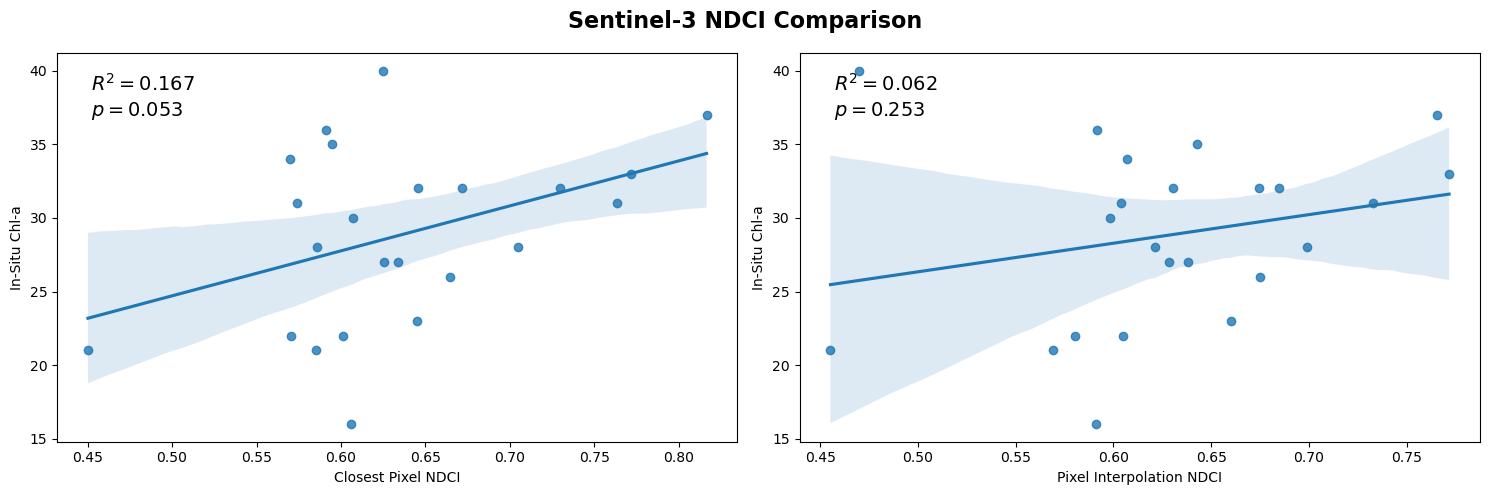

In [16]:
raster_analysis = rs(S3_NDCI, sampling_points)